In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

  Using cached https://files.pythonhosted.org/packages/3f/c0/abde58b837e066bca19a3f7332d9d0493521d7dd6b48248451a9e3fe2214/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3f/03/c3526fb4e79a793498829ca570f2f868204ad9a8040afcd72d82a8f121db/numpy-1.21.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll

In [ ]:
%tensorflow_version 1.x
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.layers import LeakyReLU, Dropout
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf


TensorFlow 1.x selected.


In [ ]:
mnist = tf.keras.datasets.mnist
#mnist_data = mnist.load_data()
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
X_train = (X_train - 127.5) / 127.5
#X_train = X_train.reshape((-1,1))
X_train.shape

(60000, 28, 28, 1)

In [ ]:
dropout = 0.4
depth = 64+64+64+64
dim = 7

In [ ]:
generator = Sequential([
        # dense - input layer
        # In: 100
        # Out: dim x dim x depth
        #Dense(depth*dim*dim, input_dim=100, activation='relu'),
        #BatchNormalization(momentum=0.9),
        #Reshape((dim,dim,depth)),
        #Dropout(dropout),
        Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((7,7,128)),
        Dropout(0.4),

        UpSampling2D(),
        Convolution2D(64, 5, strides=(1,1), padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(momentum=0.9),

        UpSampling2D(),
        Convolution2D(1, 5, strides=(1,1), padding='same', activation='tanh')
    ])

generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________

In [ ]:
discriminator = Sequential([
        Convolution2D(64, 5,  strides=2, input_shape=(28,28,1), padding='same', activation=LeakyReLU(0.2)),
        Dropout(0.4),
        Convolution2D(128, 5,  strides=2, padding='same', activation=LeakyReLU(0.2)),
        Dropout(0.4),
        Flatten(),
        Dense(1, activation='sigmoid')
   ])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [ ]:
g_optimizer = RMSprop(lr=0.0001, decay=3e-8)
#generator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
generator.compile(loss='binary_crossentropy', optimizer=g_optimizer, metrics=['accuracy'])
d_optimizer = RMSprop(lr=0.0002, decay=6e-8)
discriminator.compile(loss='binary_crossentropy', optimizer=d_optimizer, metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(ganInput, ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [ ]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size

    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)

            # getting random images from X_train of size=batch_size
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)

            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])

            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size

            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)

            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

In [ ]:
train(50, 128)

100%|██████████| 468/468 [00:15<00:00, 29.25it/s]


In [ ]:
#### we can train this some more epochs for better results

train(50, 128)

In [ ]:
train(50, 128)

In [ ]:
train(50, 128)

In [ ]:
train(50, 128)

In [ ]:
train(50, 128)

For the saving and loading to work we need to downgrade `h5py`.

In [ ]:
generator.save_weights('gen_60_scaled_images.h5')
discriminator.save_weights('dis_60_scaled_images.h5')

In [ ]:
generator.load_weights('gen_60_scaled_images.h5')
discriminator.load_weights('dis_60_scaled_images.h5')

In [ ]:
def plot_output(fake=True):

    if fake: # fake = True

      try_input = np.random.rand(100, 100)
      preds = generator.predict(try_input)

    else: # fake = False
        i = np.random.randint(0, X_train.shape[0], 100)
        preds = X_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

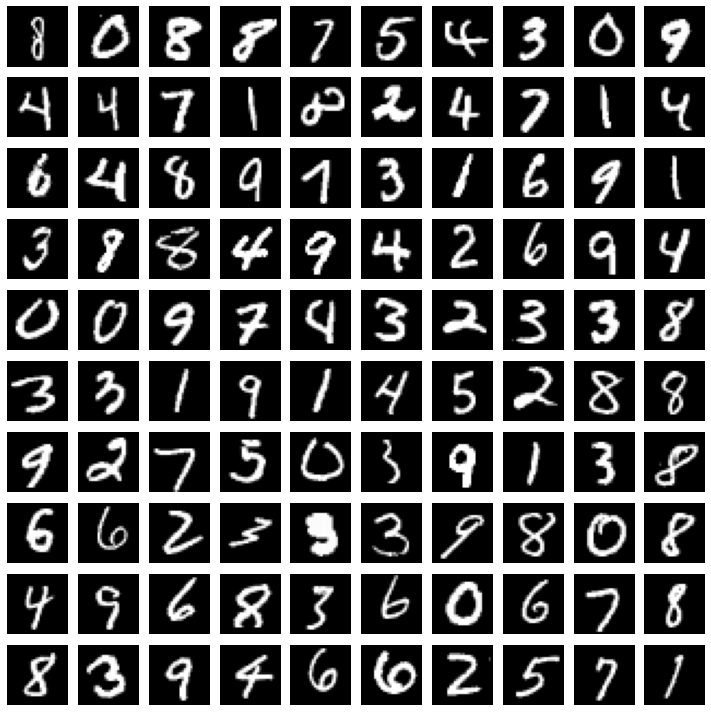

In [ ]:
plot_output(fake=False)

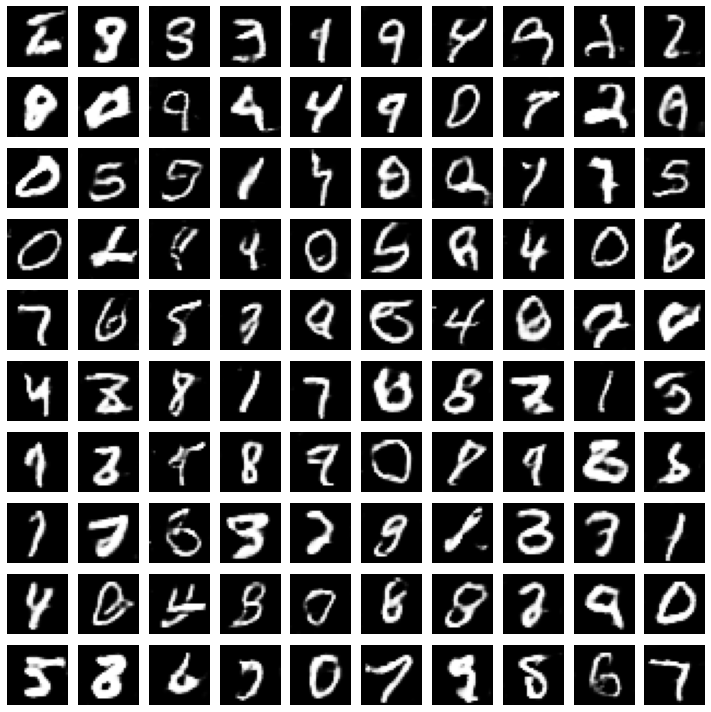

In [ ]:
plot_output()

To evaluate the model, we need to calculate the training error $\epsilon_{train}$ and the testing error $\epsilon_{test}$ using the equations below:

$$ \epsilon_{train} = \frac{1}{n}\sum_{i=1}^{n}(y_{train} - \hat{y}_{train})^2 $$

$$ \epsilon_{test} = \frac{1}{m}\sum_{i=1}^{m}(y_{test} - \hat{y}_{test})^2 $$

In which, $m$ and $n$ are the sizes of training/test sets, and $\hat{y}_{train}$ and $\hat{y}_{test}$ are the generated images.

But using the "eyeball test", we can see the generated images are of good quality.